In [1]:
from tqdm import tqdm
import os
import json
import numpy as np


In [21]:
def keys_BERT(directory, model1, model2):
    keys_only_in_model1 = set()
    keys_only_in_model2 = set()

    for filename in tqdm(os.listdir(directory)):
        if filename.startswith(f'embeddings_{model1}_words_'):
            identifier = filename.split('_')[-1].split('.')[0]  # Asumiendo que el identificador está antes de la extensión
            model2_path = f'embeddings_{model2}_words_{identifier}.json'  # Asegúrate de que la extensión sea correcta

            model1_path = os.path.join(directory, filename)
            model2_path = os.path.join(directory, model2_path)

            if os.path.isfile(model2_path):
                with open(model1_path, 'r') as model1_file, open(model2_path, 'r') as model2_file:
                    model1_data = json.load(model1_file)
                    model2_data = json.load(model2_file)

                    audio, _ = os.path.splitext(identifier)
                    model1_keys = set(model1_data[audio].keys())
                    model2_keys = set(model2_data[audio].keys())

                    # Encuentra claves que están solo en uno de los modelos
                    keys_only_in_model1.update(model1_keys - model2_keys)
                    keys_only_in_model2.update(model2_keys - model1_keys)

    return keys_only_in_model1, keys_only_in_model2

In [22]:
directory_path = '../experiments'  # Replace with the path to your directory

wav2vec_key, bert_key = keys_BERT(directory_path, model1='wav2vec2', model2='bert-base-uncased')

100%|██████████| 11457/11457 [07:34<00:00, 25.18it/s]


In [30]:
bert_key

{"'",
 'ain',
 'alexander',
 'ambrosch',
 'ann',
 'antonia',
 'apostle',
 'aren',
 'aunt',
 'author',
 'avrigny',
 'baby',
 'balvastro',
 'bambeday',
 'beenie',
 'beggar',
 'bennydeck',
 'bergez',
 'bhunda',
 'birdikins',
 'blanco',
 'body',
 'boolooroo',
 'boy',
 'bozzle',
 'brandd',
 'brau',
 'breadhouse',
 'brewer',
 'bright',
 'brother',
 'brown',
 'burgoynes',
 'can',
 'canyou',
 'cap',
 'captain',
 'captive',
 'catherine',
 'chaba',
 'charlie',
 'child',
 'chunky',
 'church',
 'citadelled',
 'clock',
 'collander',
 'commandant',
 'congal',
 'connell',
 'cook',
 'corncakes',
 'couldn',
 'culprit',
 'd',
 'daguerreotypist',
 'dante',
 'daren',
 'darfhulva',
 'darwin',
 'david',
 'day',
 'dedalos',
 'delaunay',
 'delectasti',
 'delia',
 'dent',
 'derivatively',
 'detective',
 'dhourra',
 'didn',
 'docetes',
 'doesn',
 'doma',
 'don',
 'dowle',
 'dummy',
 'e',
 'else',
 'emperor',
 'enemy',
 'er',
 'ever',
 'factor',
 'farrell',
 'father',
 'fibi',
 'finnacta',
 'fjordungr',
 'foster

# Ankita replicado

In [32]:
def linear_CKA(X, Y):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    hsic = np.linalg.norm(X_centered.T @ Y_centered, 'fro') ** 2
    var1 = np.linalg.norm(X_centered.T @ X_centered, 'fro')
    var2 = np.linalg.norm(Y_centered.T @ Y_centered, 'fro')

    return hsic / (var1 * var2)

In [75]:
directory_path = '../experiments'  # Replace with the path to your directory
glove_vs_bert = []
wav_vs_glove = []
wav_vs_bert = []
for i in range(12):
    with open(os.path.join('..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        wav2vec2_list = json.load(f)
        wav2vec2_matrix = np.array(wav2vec2_list)
    with open(os.path.join('..', 'experiments', 'layers', f'embeddings_layer{i}_bert-base-uncased.json'), 'r') as f:
        bert_list = json.load(f)
        bert_matrix = np.array(bert_list)    
    with open(os.path.join('..', 'experiments', 'layers', f'embeddings_layer{i}_glove.json'), 'r') as f:
        glove_list = json.load(f)
        glove_matrix = np.array(glove_list)  
    glove_vs_bert_i = linear_CKA(bert_matrix, glove_matrix)    
    glove_vs_bert.append(glove_vs_bert_i)
    print(f'glove vs bert for layer {i} similarity {glove_vs_bert_i}')
    wav_vs_glove_i = linear_CKA(wav2vec2_matrix, glove_matrix)
    wav_vs_glove.append(wav_vs_glove_i)
    print(f'glove vs wav2vec for layer {i} similarity {wav_vs_glove_i}')
    wav_vs_bert_i = linear_CKA(wav2vec2_matrix, bert_matrix)
    wav_vs_bert.append(wav_vs_bert_i)
    print(f'bert vs wav2vec for layer {i} similarity {wav_vs_bert_i}')


glove vs bert for layer 0 similarity 0.585699753333049
glove vs wav2vec for layer 0 similarity 0.0028213589129741715
bert vs wav2vec for layer 0 similarity 0.006571580900443021
glove vs bert for layer 1 similarity 0.5375852649005047
glove vs wav2vec for layer 1 similarity 0.09246785950292563
bert vs wav2vec for layer 1 similarity 0.15784609235462677
glove vs bert for layer 2 similarity 0.5062614845370605
glove vs wav2vec for layer 2 similarity 0.1008552442283434
bert vs wav2vec for layer 2 similarity 0.180405543422922
glove vs bert for layer 3 similarity 0.49423214178406727
glove vs wav2vec for layer 3 similarity 0.11543385586335203
bert vs wav2vec for layer 3 similarity 0.20889607935821267
glove vs bert for layer 4 similarity 0.4634834427625108
glove vs wav2vec for layer 4 similarity 0.14604251793419146
bert vs wav2vec for layer 4 similarity 0.24481473392716352
glove vs bert for layer 5 similarity 0.4186894828567838
glove vs wav2vec for layer 5 similarity 0.16896351568445997
bert vs w

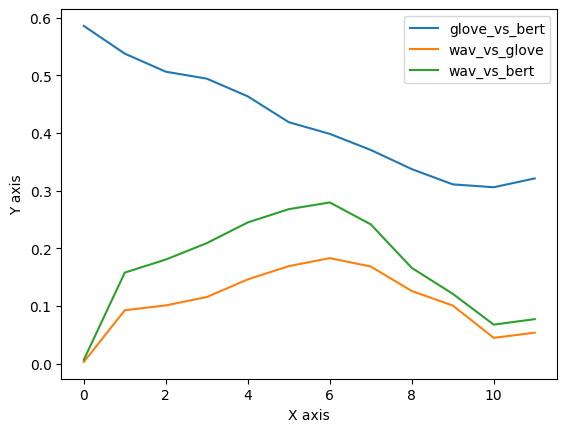

In [78]:
import matplotlib.pyplot as plt

x = range(12)
plt.plot(x, glove_vs_bert, label='glove_vs_bert')
plt.plot(x, wav_vs_glove, label='wav_vs_glove')
plt.plot(x, wav_vs_bert, label='wav_vs_bert')

plt.xlabel('Layers')
plt.ylabel('Linear CKA')
plt.legend()
plt.show()